# Test Autocorrelation

Validation for autocorr: Model the process of M—> (k)0, the autocorr should be e^(-kt)

**Codes in this note book needs to be ran using a NEW virtual environment following the guidance [here](https://swainlab.bio.ed.ac.uk/psb/byweek.html): 

- You will need to install [StochPy](http://stochpy.sourceforge.net/ there are [instructions online](http://stochpy.sourceforge.net/html/userguide.html). 

- If you have pip working — it comes with Anacaonda, then the easiest way to install is to type ``pip install stochpy`` in a terminal.
- You may need to downgrade Numpy to allow StochPy to work:
    ```
    conda install -c conda-forge numpy=1.23.0
    ```
- Alternatively you can use conda to create a dedicated virtual environment. First try
    ```
    conda create -n stochpyenv python==3.9  
    conda activate stochpyenv 
    ```
    Then

    ```
    pip install setuptools==59.8.0  
    pip install "numpy==1.23.0" scipy matplotlib jupyter  
    pip install stochpy
    ```

In [1]:
#!/usr/bin/python
import numpy as np

############# Autocorrelation and Cross-correlation ##############
def autocrosscorr(
    yA,
    yB=None,
    stationary=False,
    normalised=True,
    only_pos=False,
):
    """
    Calculate normalised auto- or cross-correlations as a function of lag.

    Lag is given in multiples of the unknown time interval between data
    points, and normalisation is by the product of the standard
    deviation over time for each replicate for each variable.

    For the cross-correlation between sA and sB, the closest peak to zero
    lag should be in the positive lags if sA is delayed compared to
    signal B and in the negative lags if sA is advanced compared to
    signal B.

    Parameters
    ----------
    yA: array
        An array of signal values, with each row a replicate measurement
        and each column a time point.
    yB: array (required for cross-correlation only)
        An array of signal values, with each row a replicate measurement
        and each column a time point.
    stationary: boolean
        If True, the underlying dynamic process is assumed to be
        stationary with the mean a constant, estimated from all
        data points.
    normalised: boolean (optional)
        If True, normalise the result for each replicate by the standard
        deviation over time for that replicate.
    only_pos: boolean (optional)
        If True, return results only for positive lags.

    Returns
    -------
    corr: array
        An array of the correlations with each row the result for the
        corresponding replicate and each column a time point
    lags: array
        A 1D array of the lags in multiples of the unknown time interval

    Example
    -------
    >>> import matplotlib.pyplot as plt
    >>> import numpy as np

    Define a sine signal with 200 time points and 333 replicates

    >>> t = np.linspace(0, 4, 200)
    >>> ts = np.tile(t, 333).reshape((333, 200))
    >>> s = 3*np.sin(2*np.pi*ts + 2*np.pi*np.random.rand(333, 1))

    Find and plot the autocorrelaton

    >>> ac, lags = autocrosscorr(s)
    >>> plt.figure()
    >>> plt.plot(lags, np.nanmean(ac, axis=0))
    >>> plt.show()

    Reference
    ---------
    Dunlop MJ, Cox RS, Levine JH, Murray RM, Elowitz MB (2008). Regulatory
    activity revealed by dynamic correlations in gene expression noise.
    Nat Genet, 40, 1493-1498.
    """
    # number of replicates & number of time points
    nr, nt = yA.shape
    # autocorrelation
    if yB is None:
        yB = yA
    # find deviation from the mean
    dyA, stdA = _dev(yA, nr, nt, stationary)
    dyB, stdB = _dev(yB, nr, nt, stationary)
    # calculate correlation
    # lag r runs over positive lags
    pos_corr = np.nan * np.ones(yA.shape)
    for r in range(nt):
        prods = [dyA[:, t] * dyB[:, t + r] for t in range(nt - r)]
        pos_corr[:, r] = np.nanmean(prods, axis=0)
    # lag r runs over negative lags
    # use corr_AB(-k) = corr_BA(k)
    neg_corr = np.nan * np.ones(yA.shape)
    for r in range(nt):
        prods = [dyB[:, t] * dyA[:, t + r] for t in range(nt - r)]
        neg_corr[:, r] = np.nanmean(prods, axis=0)
    if normalised:
        # normalise by standard deviation
        pos_corr = pos_corr / stdA / stdB
        neg_corr = neg_corr / stdA / stdB
    # combine lags
    lags = np.arange(-nt + 1, nt)
    corr = np.hstack((np.flip(neg_corr[:, 1:], axis=1), pos_corr))
    # return correlation and lags
    if only_pos:
        return corr[:, int(lags.size / 2) :], lags[int(lags.size / 2) :]
    else:
        return corr, lags

def _dev(y, nr, nt, stationary=False):
    # calculate deviation from the mean
    if stationary:
        # mean calculated over time and over replicates
        dy = y - np.nanmean(y)
    else:
        # mean calculated over replicates at each time point
        dy = y - np.nanmean(y, axis=0).reshape((1, nt))
    # standard deviation calculated for each replicate
    stdy = np.sqrt(np.nanmean(dy**2, axis=1).reshape((nr, 1)))
    return dy, stdy

Birth-death process

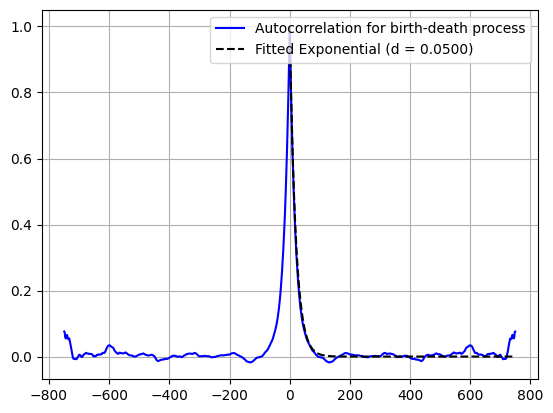

In [ ]:
##### test_autocrosscorr_birthdeath.py
import numpy as np
import matplotlib.pyplot as plt
import stochpy
# from stats.autocorrelation import autocrosscorr

smod = stochpy.SSA(model_file="birth_death.psc", dir="/home/ianyang/stochastic_simulations/tests/autocrosscorr")

# birth rate
k0 = 5
# death rate
d0 = 0.05
# final time of simulation
tf = 1500

# load the stochastic birth-death model
smod.ChangeParameter("k", k0)
smod.ChangeParameter("d", d0)

if False:
    # simulate stochastically
    smod.DoStochSim(end=tf, mode="time", trajectories=3, quiet=False)
    # plot the results
    smod.PlotSpeciesTimeSeries()
    plt.xlim([0, tf])
    plt.show()

# run many simulations
smod.DoStochSim(end=tf, mode="time", trajectories=500, quiet=False)

# put the trajectories on a grid - a matrix - with regularly spaced time points
ns = 1000
dt = np.mean(np.diff(np.linspace(0, tf, ns)))
timesavailable = np.linspace(0, tf, ns)
smod.GetRegularGrid(n_samples=ns)
# each row is one trajectory
data = np.array(smod.data_stochsim_grid.species[0]).astype("float")

# autocorrelation
ac, lags = autocrosscorr(data[:, int(ns / 2) :])
plt.figure()
t = dt * np.arange(int(ns / 2))
plt.plot(dt * lags, np.mean(ac, axis=0), "b-", label="Autocorrelation for birth-death process")
plt.plot(t, np.exp(-t * d0), "k--", label=f'Fitted Exponential (d = {d0:.2f})')
plt.legend()
plt.grid()
plt.show()


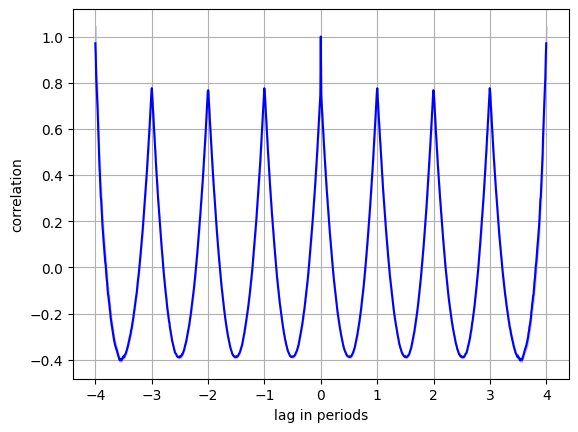

In [4]:
# test_autocrosscorr_sawtooth.py
import numpy as np
from scipy import signal
# from wela.autocrosscorr import autocrosscorr
from matplotlib import pyplot as plt

def plot_replicate_array(
    data,
    t=None,
    plotmean=True,
    xlabel=None,
    ylabel=None,
    title=None,
    grid=True,
    showdots=False,
    show=True,
):
    """
    Plot summary statistics versus axis 1 (time) for an array of replicates.

    Parameters
    ----------
    data: array
        An array of signal values, with each row a replicate measurement
        and each column a time point.
    t : array (optional)
        An array of time points.
    plotmean: boolean
        If True, plot the mean correlation over replicates versus the lag
        with the standard error.
        If False, plot the median correlation and the interquartile range.
    xlabel: string
        Label for x-axis.
    ylabel: string
        Label for y-axis.
    title: string
        Title for plot.
    grid: boolean
        If True, draw grid on plot.
    showdots: boolean
        If True, show individual data points.
    show: boolean
        If True, display figure immediately.
    """
    # number of time points
    n = data.shape[1]
    # number of replicates
    nr = data.shape[0]
    if not np.any(t):
        t = np.arange(n)
    if showdots:
        plt_type = "b.-"
    else:
        plt_type = "b-"
    if show:
        plt.figure()
    if plotmean:
        # mean and standard error
        plt.plot(t, np.nanmean(data, axis=0), plt_type)
        stderr = np.nanstd(data, axis=0) / np.sqrt(nr)
        plt.fill_between(
            t,
            np.nanmean(data, axis=0) + stderr,
            np.nanmean(data, axis=0) - stderr,
            color="b",
            alpha=0.2,
        )
    else:
        # median and interquartile range
        plt.plot(t, np.nanmedian(data, axis=0), plt_type)
        plt.fill_between(
            t,
            np.nanquantile(data, 0.25, axis=0),
            np.nanquantile(data, 0.75, axis=0),
            color="b",
            alpha=0.2,
        )
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if title:
        plt.title(title)
    if grid:
        plt.grid()
    if show:
        plt.show(block=False)

nr = 200
nt = 500
period = 8
t = np.linspace(0, period * 4, nt)
ts = np.tile(t, nr).reshape((nr, nt))
y = signal.sawtooth(t * 2 * np.pi / period + 2 * np.pi * np.random.rand(nr, 1))
data = 10 + y + np.random.normal(0, 0.3, y.shape)

# autocorrelation
ac, lags = autocrosscorr(data, stationary=False)
plot_replicate_array(
    ac,
    t=lags * np.median(np.diff(t)) / period,
    xlabel="lag in periods",
    ylabel="correlation",
)


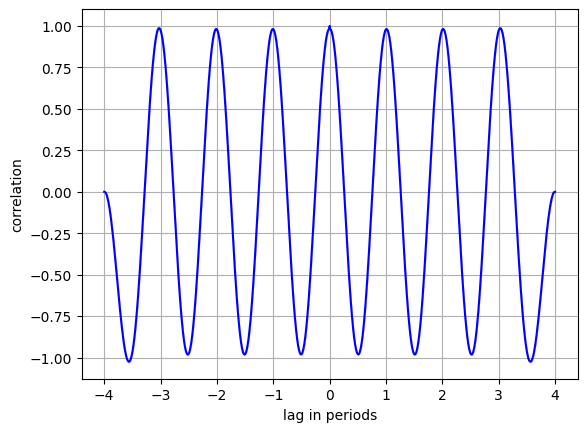

In [10]:
# test_autocrosscorr_sine.py
import numpy as np
# from wela.autocrosscorr import autocrosscorr
# from wela.plotting import plot_replicate_array
def plot_replicate_array(
    data,
    t=None,
    plotmean=True,
    xlabel=None,
    ylabel=None,
    title=None,
    grid=True,
    showdots=False,
    show=True,
):
    """
    Plot summary statistics versus axis 1 (time) for an array of replicates.

    Parameters
    ----------
    data: array
        An array of signal values, with each row a replicate measurement
        and each column a time point.
    t : array (optional)
        An array of time points.
    plotmean: boolean
        If True, plot the mean correlation over replicates versus the lag
        with the standard error.
        If False, plot the median correlation and the interquartile range.
    xlabel: string
        Label for x-axis.
    ylabel: string
        Label for y-axis.
    title: string
        Title for plot.
    grid: boolean
        If True, draw grid on plot.
    showdots: boolean
        If True, show individual data points.
    show: boolean
        If True, display figure immediately.
    """
    # number of time points
    n = data.shape[1]
    # number of replicates
    nr = data.shape[0]
    if not np.any(t):
        t = np.arange(n)
    if showdots:
        plt_type = "b.-"
    else:
        plt_type = "b-"
    if show:
        plt.figure()
    if plotmean:
        # mean and standard error
        plt.plot(t, np.nanmean(data, axis=0), plt_type)
        stderr = np.nanstd(data, axis=0) / np.sqrt(nr)
        plt.fill_between(
            t,
            np.nanmean(data, axis=0) + stderr,
            np.nanmean(data, axis=0) - stderr,
            color="b",
            alpha=0.2,
        )
    else:
        # median and interquartile range
        plt.plot(t, np.nanmedian(data, axis=0), plt_type)
        plt.fill_between(
            t,
            np.nanquantile(data, 0.25, axis=0),
            np.nanquantile(data, 0.75, axis=0),
            color="b",
            alpha=0.2,
        )
    if xlabel:
        plt.xlabel(xlabel)
    if ylabel:
        plt.ylabel(ylabel)
    if title:
        plt.title(title)
    if grid:
        plt.grid()
    if show:
        plt.show(block=False)


nr = 200
nt = 500
addrandomphase = False
period = 8
t = np.linspace(0, period * 4, nt)
ts = np.tile(t, nr).reshape((nr, nt))
if addrandomphase:
    y = 3 * np.sin(2 * np.pi * ts / period + 2 * np.pi * np.random.rand(nr, 1))
else:
    y = 3 * np.sin(2 * np.pi * ts / period)
data = 10 + y + np.random.normal(0, 0.3, y.shape)

# autocorrelation
ac, lags = autocrosscorr(data, stationary=True)
plot_replicate_array(
    ac,
    t=lags * np.median(np.diff(t)) / period,
    xlabel="lag in periods",
    ylabel="correlation",
)


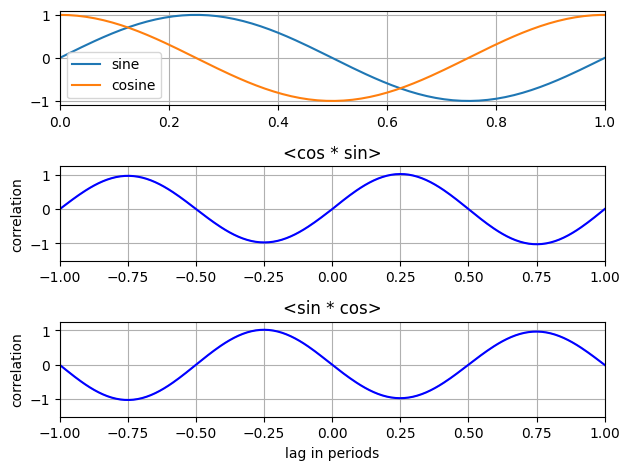

In [11]:
# test_autocrosscorr_x.py
import numpy as np
import matplotlib.pylab as plt
# from wela.autocrosscorr import autocrosscorr
# from wela.plotting import plot_replicate_array

nr = 1000
nt = 500
period = 8
noise_sig = 0.01
t = np.linspace(0, period * 4, nt)
ts = np.tile(t, nr).reshape((nr, nt))

final_t = 2 * np.pi * ts / period + np.pi / 4 * np.random.rand(nr, 1)
y = 3 * np.sin(final_t)
s_sin = 10 + y + np.random.normal(0, noise_sig, y.shape)
z = 3 * np.cos(final_t)
s_cos = 10 + z + np.random.normal(0, noise_sig, z.shape)

# correlation
cs, lags = autocrosscorr(s_cos, s_sin)
sc, lags = autocrosscorr(s_sin, s_cos)

# cosine is delayed by period/4 = pi/2 compared to sine
plt.figure()
plt.subplot(3, 1, 1)
plt.plot(t / period, np.sin(2 * np.pi * t / period), label="sine")
plt.plot(t / period, np.cos(2 * np.pi * t / period), label="cosine")
plt.legend()
plt.grid()
plt.xlim([0, 1])
plt.subplot(3, 1, 2)
# peaks at 0.25
plot_replicate_array(
    cs,
    t=lags * np.median(np.diff(t)) / period,
    ylabel="correlation",
    title="<cos * sin>",
    show=False,
)
plt.xlim([-1, 1])
plt.subplot(3, 1, 3)
# peaks at -0.25
plot_replicate_array(
    sc,
    t=lags * np.median(np.diff(t)) / period,
    xlabel="lag in periods",
    ylabel="correlation",
    title="<sin * cos>",
    show=False,
)
plt.xlim([-1, 1])
plt.tight_layout()
plt.show()


In [6]:
from wela.autocrosscorr import autocrosscorr
from wela.plotting import plot_replicate_array
import pandas as pd

df = pd.read_csv("by4741_omero20016.csv")
v = df.drop("cellID", axis=1).to_numpy()
ac, lags = autocrosscorr(v)
plot_replicate_array(ac, t=lags * 5 / 60, xlabel="lag", ylabel="correlation")


FileNotFoundError: [Errno 2] No such file or directory: 'by4741_omero20016.csv'